In [1]:
import pickle
import pandas as pd
from pathlib import Path
import bz2

In [3]:
data_path = Path('./data/').resolve()
file_path = data_path/'products_20200901.txt' 

### Fix the card labels and doc labels

In [2]:
with open("doc_lbe.pkl", "rb") as f:
    doc_lbe = pickle.load(f)

In [3]:
with open("card_lbe.pkl", "rb") as f:
    card_lbe = pickle.load(f) 

In [5]:
with bz2.open(data_path / '09_prepared.pkl.bz2', 'rb') as f:
    df = pickle.load(f)

In [6]:
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.0,108.00,False,1118108,422300
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271,1.0,108.00,False,204303,2923150
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271,1.0,107.95,False,456063,4186546
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271,1.0,108.00,False,333334,7089452
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97,2.0,88.00,False,782332,211162


In [7]:
df["id_card_int"] = card_lbe["id_card_int"]
df["id_doc_int"] = doc_lbe["id_doc_int"]

In [8]:
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.0,108.00,False,1538855.0,1283228.0
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271,1.0,108.00,False,267307.0,8873113.0
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271,1.0,107.95,False,610220.0,12712899.0
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271,1.0,108.00,False,441497.0,21535283.0
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97,2.0,88.00,False,1065358.0,642341.0


In [9]:
import bz2
with bz2.open(data_path / '09_prepared_for_stats.pkl.bz2', 'wb') as f:
    pickle.dump(df, f, protocol=4)

### Homework starts

#### TL;DR;

To find potential bots I grouped products which was bought online by order id and using 5% and 95% quantiles filter the data for further anomaly investigation. After that, I found that guys which has bought products in 5% percentile is someone who want to buy gum, water or smth like that, so that I decided to investigate outliers from the right tail (i.e. between 95% and 100% percentile). To find suspicious activity I retrieved all buying history of those guys and marked whose who made only one transaction in history as anomalous guys

In [4]:
# load data
with bz2.open(data_path / '09_prepared_for_stats.pkl.bz2', 'rb') as f:
    df = pickle.load(f)

In [6]:
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.0,108.00,False,1538855.0,1283228.0
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271,1.0,108.00,False,267307.0,8873113.0
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271,1.0,107.95,False,610220.0,12712899.0
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271,1.0,108.00,False,441497.0,21535283.0
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97,2.0,88.00,False,1065358.0,642341.0


In [7]:
df.id_card.nunique()

1358089

The 1st step is to remove customers which buys products offline. The motivation is that our research question is to find users that are not real customers (or trolls) and physically it is hard to be possible (i.e. to be a not real customer) for offline buyings.

In [9]:
df_online = df[df.id_order!=0]

In [10]:
df_online.shape

(5385728, 11)

In [11]:
df_online.shape[0]/df.shape[0]

0.12792442377302618

As we can see we have drastically decrease the amount of data. The amount of buyings which were performed online is only 12.8% from all transactions

In [34]:
sum_of_order = df_online.groupby(["id_order"])["sum"].sum()

In [64]:
sum_of_order.describe()

,sum
count,503504.000000
mean,1349.496831
std,1128.310615
min,0.000000
25%,591.400000
50%,1040.980000
75%,1753.672500
max,48005.000000


<AxesSubplot:>

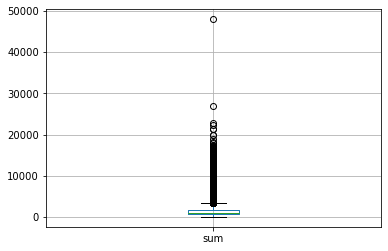

In [37]:
sum_of_order = pd.DataFrame(sum_of_order)
sum_of_order.boxplot()

We have found that there are some strange activity, because our minimal receipt is equal to 0 and maximum to 48005 RUB 

In [38]:
sum_of_order[sum_of_order["sum"] > 40000]

,sum
id_order,
6518049,48005.0


In [165]:
df_online[df_online.id_order==6518049]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
38058645,2020-09-28 08:36:51,9B6A36BF-4C01-EB11-B444-005056A7539A,6518049,A634010,647,13567,1.0,5.0,False,NaN,NaN
38060133,2020-09-28 08:36:51,9B6A36BF-4C01-EB11-B444-005056A7539A,6518049,A634010,21379,15189,4.0,9600.0,False,NaN,NaN
38060134,2020-09-28 08:36:51,9B6A36BF-4C01-EB11-B444-005056A7539A,6518049,A634010,21379,18018,16.0,38400.0,False,NaN,NaN


OMG! This guy is really addicted on caviar!

In [81]:
# let's choose left and right hand site tails according to quantiles and investigate them
lhs_suspects = sum_of_order[sum_of_order["sum"] <= sum_of_order.quantile(0.05)["sum"]]
rhs_suspects = sum_of_order[sum_of_order["sum"] >= sum_of_order.quantile(0.95)["sum"]]

In [99]:
lhs_suspects.describe()

,sum
count,25177.00000
mean,160.91439
std,57.42908
min,0.00000
25%,119.00000
50%,170.00000
75%,209.14000
max,243.00000


<AxesSubplot:>

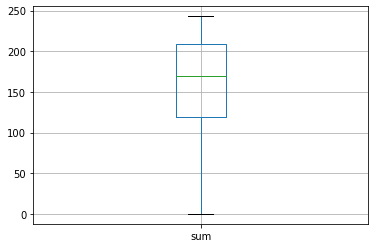

In [84]:
lhs_suspects.boxplot()

Let's look for the order with 0 sum

In [167]:
df_online[df_online.id_order==3938925]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
1043004,2020-09-01 10:45:45,40B0BD5D-27EC-EA11-B444-005056A7539A,3938925,A361864,27128,-9999,1.0,0.0,False,307755.0,17056704.0


Now let's investigate its customer history

In [168]:
df_online[df_online.id_card=="A361864"]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
1043004,2020-09-01 10:45:45,40B0BD5D-27EC-EA11-B444-005056A7539A,3938925,A361864,27128,-9999,1.0,0.0,False,307755.0,17056704.0
31551195,2020-09-23 09:03:05,646B61BD-62FD-EA11-B444-005056A7539A,5932286,A361864,27128,-9999,1.0,1100.0,False,NaN,NaN
31551196,2020-09-23 09:03:26,666B61BD-62FD-EA11-B444-005056A7539A,5932286,A361864,27128,-9999,1.0,1100.0,False,NaN,NaN
34506305,2020-09-25 08:47:44,ED247E05-F3FE-EA11-B444-005056A7539A,5932286,A361864,27128,-9999,1.0,1100.0,False,NaN,NaN
34506306,2020-09-25 08:48:08,F0247E05-F3FE-EA11-B444-005056A7539A,5932286,A361864,27128,-9999,1.0,1100.0,False,NaN,NaN


Oh, this guy bought the same category previously, so maybe it is some promo. To accept this let's have a look on descriptive statistics of this good

In [169]:
df_online[df_online.id_tov==27128]["sum"].describe()

count     124.000000
mean     1104.354839
std       145.020279
min         0.000000
25%      1020.000000
50%      1150.000000
75%      1200.000000
max      1250.000000
Name: sum, dtype: float64

In [170]:
tmp = df_online[df_online.id_tov==27128]
tmp[tmp["sum"]==0]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
1043004,2020-09-01 10:45:45,40B0BD5D-27EC-EA11-B444-005056A7539A,3938925,A361864,27128,-9999,1.0,0.0,False,307755.0,17056704.0


As we can see there is only one buying of this good with 0 buying, so maybe it is really some promo

Investigation of the right hand side tail

In [172]:
rhs_suspects.describe()

,sum
count,25176.000000
mean,4754.681791
std,1461.714354
min,3488.030000
25%,3819.742500
50%,4297.830000
75%,5166.155000
max,48005.000000


<AxesSubplot:>

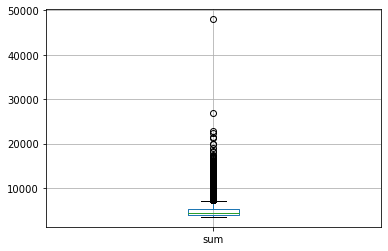

In [173]:
rhs_suspects.boxplot()

In [174]:
rhs_suspect_outliers = rhs_suspects[rhs_suspects["sum"] >= 8000]

In [175]:
rhs_suspect_outliers.describe()

,sum
count,878.000000
mean,9949.670923
std,2541.978834
min,8000.680000
25%,8450.832500
50%,9186.115000
75%,10542.937500
max,48005.000000


In [176]:
rhs_suspect_outliers

,sum
id_order,
218202,9324.10
396783,8254.75
1081817,14369.98
1552779,10337.00
1953457,8293.00
...,...
6661531,11086.45
6662703,8835.95
6662903,9189.62


In [180]:
def get_info_from_previous_orders(previous_orders):
    orders = {}
    for id_order in previous_orders.index:
        order = df_online[df_online.id_order==id_order]
        order_len = order.shape[0]
        orders[id_order] = {"order_len": order_len, "order_sum": previous_orders[id_order]}
    return orders

In [181]:
# Collect order history
orders_info = {}
for id_order in rhs_suspect_outliers.index:
    suspect_order = df_online[df_online.id_order==id_order]
    id_card = suspect_order.id_card.iloc[0]
    suspect_order_length = suspect_order.shape[0]
    previous_orders = df_online[df_online.id_card == id_card].groupby(["id_order"])["sum"].sum()
    previous_orders = get_info_from_previous_orders(previous_orders)
    orders_info[id_card] = {"suspect_order_length": suspect_order_length,
                            "suspect_order_id": id_order,
                            "previous_orders": previous_orders}

In [195]:
potential_bots = []
for suspect_user in orders_info:
    if len(orders_info[suspect_user]['previous_orders'])==1: # 1 is because suspicious transaction also included in history
        potential_bots.append(suspect_user)

In [199]:
print("Potential list of bots:")
for bot in potential_bots:
    print(bot)

Potential list of bots:
8382225
2451998
5118657
8915968
a699161
a678880
3180009
6551259
7381210
3921112
9510442
0804547
0957798
5014556
6784927
4879050
7567769
0371435
3861427
3082343
7168683
5837708
4531723
2242497
a689162
7434542
5885807
c444148
7775530
a615973
c447624
3836157
1830436
1240384
6804003
3771784
c450004
a672021
3746990
a702553
a557406
3927199
a861067
A665960
4800615
a285171
6025157
5508081
2251919
2648523
C403344
A251814
4296323
B006753
4963306
3095886
4759962
0674776
8161055
6632070
9165556
9672656
4260442
A679514
6968467
1335838
5621822
4551339
A388970
3813924
1584122
4743895
7849530
C400460
2241267
9865008
5336922
4952931
a251814
0527647
0356186
0569526
0870013
2908302
4419494
c493613
1421301
2822539
C475432
6138205
1759324
2863936
A615973
5802771
0027631
a574088
c498062
8565450
0208942
0219883
c486228
3712231
A689463
8423037
3978861
c461875
A672734
6319407
a604404
1117761
0884107
3690561
c514335
7798100
9158746
0757744
6034709
3285905
2756447
0477242
A634010
a762114
